Import necessary libraries.

In [70]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

Ask user to input stock symbol and date range

In [90]:
stock_symbol = input("Enter the stock symbol (e.g., AAPL): ").upper()
days_to_predict = int(input("Enter the number of days to predict: "))
start_date = input("Enter start date of stock data (e.g., 1980-01-01): ")
end_date = input("Enter end date of stock data (e.g., 2024-03-01): ")

Download and scale stock data using YFinance.
For this model, we download closing prices for the stock and scale them to the range of 0-1.

In [91]:
df = yf.download(stock_symbol, start_date, end_date)
df = df[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Initializing train and test data by dividing the scaled data. 
Since we chose 0.75, 75% of data will be used as training data and 25% will be used for testing.

In [93]:
time_step = 50  
train_size = int(len(scaled_data) * 0.75)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

Creating datasets for training and testing. 
X_train and X_test are sequences with length time_step that stores the prices in 50 days, while y_train and y_test store the price on the next day.
This way, y_train and y-test can be used as feedback as they provide the correct prices for the model's supervised learning.

We also reshape the X_train and X_test into the following format: (# of samples, time_steps, 1) where the "1" is for output.

In [94]:
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

This is where we make our model.
We first make a sequential model with a linear path for layers.
Then, we add 3 LSTM layers and 1 dense to it, and finally compiling the model to configure it for training using Adam as the optimizer and mean squared error as the loss function.

In [95]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fitting (training) the model using train data. Epochs and batch size can be adjusted. This step can take quite a while...

In [104]:
model.fit(X_train, y_train, epochs=64, batch_size=128)

Epoch 1/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 7.4395e-06
Epoch 2/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.4205e-06
Epoch 3/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.0183e-06
Epoch 4/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.7896e-06
Epoch 5/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.1336e-06
Epoch 6/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 2.4315e-06
Epoch 7/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 2.6196e-06
Epoch 8/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.4880e-06
Epoch 9/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 2.5603e-06
Epoch 10/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 2.5652e-06
Epoch 11/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.3674e-06
Epoch 12/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.7921e-06
Epoch 13/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.1563e-06
Epoch 14/64
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 2.8962e-06
Epoch 15/64
21/

Testing the model by using it to predict the test data.

In [105]:
test_predictions = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Plotting the result of our test

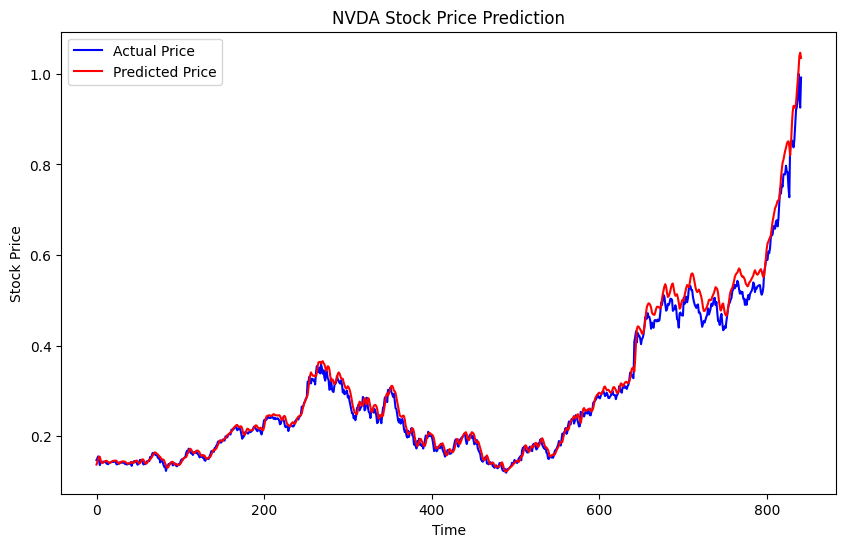

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', label='Actual Price')
plt.plot(test_predictions, color='red', label='Predicted Price')
plt.title(stock_symbol+' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Printing the error as a quantity (mean squared error), multiplying it for better readability

In [107]:
mse = mean_squared_error(y_test, test_predictions)*1000
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.40796407657056155


In [108]:
# Prepare last_n_days for prediction
last_n_days = scaled_data[-time_step:, :]  # Use the last time_step days for prediction
X_predict = np.array(last_n_days).reshape(1, time_step, 1)

# Make predictions for the next n days
predicted_prices = []
for _ in range(days_to_predict):
    prediction = model.predict(X_predict)
    predicted_prices.append(prediction[0, 0])
    X_predict = np.roll(X_predict, -1, axis=1)  # Shift data to the left along the time axis
    X_predict[0, -1, 0] = prediction[0, 0]  # Set the last value to the predicted value

# Inverse transform the predicted prices
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

predicted_prices



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

array([[ 976.0628 ],
       [1005.54016],
       [1042.8064 ],
       [1081.4545 ],
       [1119.0245 ],
       [1154.8455 ],
       [1188.9391 ],
       [1221.593  ],
       [1253.1812 ],
       [1284.0557 ],
       [1314.4846 ],
       [1344.6241 ],
       [1374.514  ],
       [1404.1019 ],
       [1433.2698 ],
       [1461.8683 ],
       [1489.742  ],
       [1516.7512 ],
       [1542.7842 ],
       [1567.7593 ],
       [1591.6277 ],
       [1614.3655 ],
       [1635.9711 ],
       [1656.4578 ],
       [1675.8499 ],
       [1694.1804 ],
       [1711.4844 ],
       [1727.8    ],
       [1743.1659 ],
       [1757.622  ]], dtype=float32)

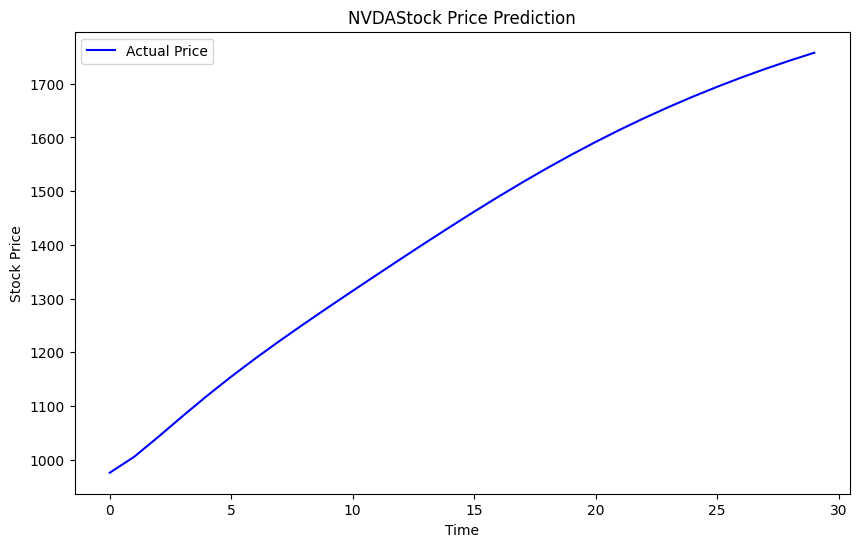

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_prices, color='blue', label='Actual Price')
plt.title(stock_symbol+'Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()